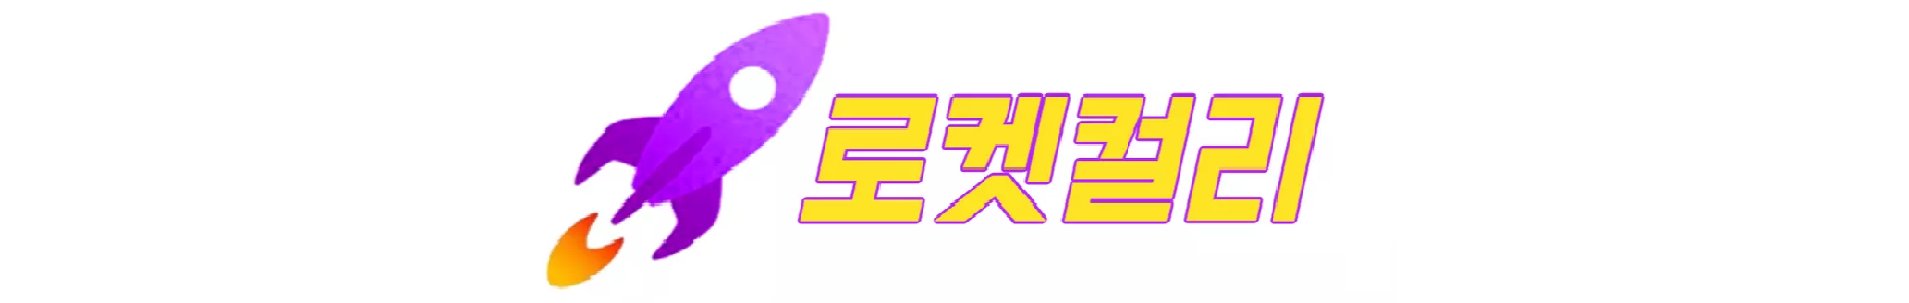

# 로켓컬리 (RocketKurly) in DATATON


안녕하세요. 로켓컬리입니다. 
  
저희는 김종태, 김선우, 차윤겸, 이성현으로 구성된 팀입니다.  


이번에 발표할 내용은 2017년 케글에서 진행됐던 'Instacart Market Basket Analysis'이며  
주제는 'Which products will an Instacart consumer purchase again?' 즉, '고객들은 어떤 상품을 재구매 할까?'입니다.  
https://www.kaggle.com/c/instacart-market-basket-analysis

  
이번 데이터 톤에서 저희는 주어진 데이터를 이용해 다음 세 가지 목표를 설정했습니다.  
- 테이터를 가지고 고객의 마음을 읽어보자.
- 고객의 정보를 홍보팀에 쉽고, 빠르고, 정확하게, 그리고 예술적으로 브리핑해보자.
- VIP고객을 분류하고, 어떤 고객(who)에게 어떤 상품(what)에 대한 혜택을 언제(when) 제공해야 하며 그 근거(why)는 무엇인지 밝혀보자.  
입니다.  

  
그럼 이제 데이터 속으로 빠져 보겠습니다.


    




# 사전 준비

In [1]:
# 우선 구글 colab의 drive를 연결합니다.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Import

In [2]:
# 각종 필요한 라이브러리를 import 하고 data를 받아옵니다.

import os
from os.path import join

import pandas as pd
import numpy as np

from PIL import Image
from wordcloud import WordCloud     # word cloud
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import missingno as msno           # 결측치를 확인하기위해서 사용하는 모듈

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from subprocess import check_output
%matplotlib inline
# import joypy
# from joypy import joyplot

import pickle



print('IMPORT 완료💢')

IMPORT 완료💢


- DATA 읽어오기 & Merge

In [3]:
# # data는 총 7개이며 이를 모두 merge합니다.(이미 실행한 파일이므로 다시 실행하지 않겠습니다.)

# order_products_train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/order_products__train.csv/order_products__train.csv")
# order_products_prior_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/order_products__prior.csv/order_products__prior.csv")
# orders_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/orders.csv/orders.csv")
# products_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/products.csv/products.csv")
# aisles_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/aisles.csv/aisles.csv")
# departments_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/departments.csv/departments.csv")

# # merge 순서는 다음과 같습니다.
# product_merge_df = pd.concat(order_products_prior_df, order_products_train_df)
# The_merge_df = pd.merge(orders_df, product_merge_df, how='left')
# The_merge_df = pd.merge(The_merge_df, products_df, how='left')
# The_merge_df = pd.merge(The_merge_df, aisles_df, how='left')
# The_merge_df = pd.merge(The_merge_df, departments_df, how='left')

# # merge가 완료된 df는 용량이 작은 parquet 파일 형식으로 저장합니다.
# The_merge_df.to_parquet('/content/drive/MyDrive/Colab Notebooks/dataton/data/The_merge.parquet')

# 파일을 다시 실행할 때는 필요에 따라 파일을 불러옵니다.
total_df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/dataton/data/The_merge.parquet")      # 전체가 merge된 파일 불러오기 total_df
orders_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataton/data/orders.csv/orders.csv")     # 필요에 따라 용량이 작은 파일도 불러옵니다.

total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33894106 entries, 0 to 33894105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              float64
 8   add_to_cart_order       float64
 9   reordered               float64
 10  product_name            object 
 11  aisle_id                float64
 12  department_id           float64
 13  aisle                   object 
 14  department              object 
dtypes: float64(6), int64(5), object(4)
memory usage: 4.0+ GB


- 함수 정의

In [75]:
def mk_list(id, col):
  '''
  orders_df 에서 user_id에 해당해는 coloum의 내용을 리스트로 만들어 주는 함수.
  '''
  index_list = user_gb_groups[id]
  return list(orders_df.loc[index_list,col])


def no_30(df):
  '''
    df를 전달 받으면 dspo 30인 데이터를 가진 user_id를 지우는 함수
    아래 te부분을 활성화 하면 test 데이터도 지움.
  '''
  total_delete_dspo_30 = df[df['days_since_prior_order']==30]                                          # dspo가 30인 것들 추리기
  
  total_delete_dspo_30_userid = total_delete_dspo_30['user_id']                                         # user_id만 가져오기
  total_delete_dspo_30_userid = total_delete_dspo_30_userid.to_frame()                                 # b를 Series --> dataframe으로 바꿔준다
  total_delete_dspo_30_userid = total_delete_dspo_30_userid.drop_duplicates(['user_id'])               # 중복 user_id제거 drop_duplicates

  no_30 = df.loc[~df['user_id'].isin(total_delete_dspo_30_userid['user_id'])]               # total_df의 user_id 에서 b의user_id가 없는 거 추출

  # te까지 제거 
  no_30 = no_30.loc[no_30['eval_set'] != 'test']                  # no_30에서 eval_set이 test인 데이터 제거

  return no_30


def user_id_list(df):
  ''' df를 받으면 user_id의 리스트를 반환하는 함수 '''
  user_gb_ = df.groupby('user_id')
  user_gb_groups_ = user_gb_.groups
  user_id_list_ = user_gb_groups_.keys()
  return list(user_id_list_)


def cal_mean_std(customer):
    """
        전달받은 customer에따라 total_df에서 해당하는 고객의 데이터를 가져온 후,
        user_id별 days_since_prior_orderd의 데이터를 user_df에 저장
        해당 데이터 프레임의 평균(mean)과 표준편차(std) 를 출력해주는 함수
    """

    df = orders_df[orders_df['eval_set'] == customer]
    user_df = df['days_since_prior_order'].groupby(df['user_id'])

    print('==============================================')
    print(f'고객 유형 : {customer}')
    #print(f'총 합계 : {user_df.sum()}')
    print(f'평균 : {user_df.mean()}\n')
    print(f'표준편차 : {user_df.std()}')


def wc(df, id, a):
  '''
  df를 받아 wordcloud를 그려주는 함수
  '''
  
  merge_df = pd.merge(total_df, df, on='user_id', how='inner')

  merge_df = merge_df['aisle'].value_counts().reset_index() 
  merge_df.columns = ['product_name', 'f_count']

  rank = merge_df.set_index("product_name").to_dict()["f_count"]

  mask =  np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/dataton/image/rocket.png'))

  wordcloud = WordCloud(
    font_path = '/content/drive/MyDrive/Colab Notebooks/dataton/etc/Room No.703.ttf',
    width =400,
    height = 400,
    max_words = 100,
    random_state=10*a,
    colormap='Set'+str(a),    
    mask = mask,
    max_font_size= 400,
    background_color = 'white'
  ).generate_from_frequencies(rank)
  
  return wordcloud


# 데이터 전처리 

- 데이터 설명  
  
  

aisles_df : 통로 = 물건의 위치번호(ex - 과자-> 1번 매대)  <소분류>

departments_df : 식료품과 번호 정보  <대분류>

order_products_prior_df : proir(이전구매)의 구매 이력정보

order_products_train_df : train(현재구매)의 구매 이력정보

orders_df : 주문 데이터

products_df : 상품 데이터

- 결측치 확인

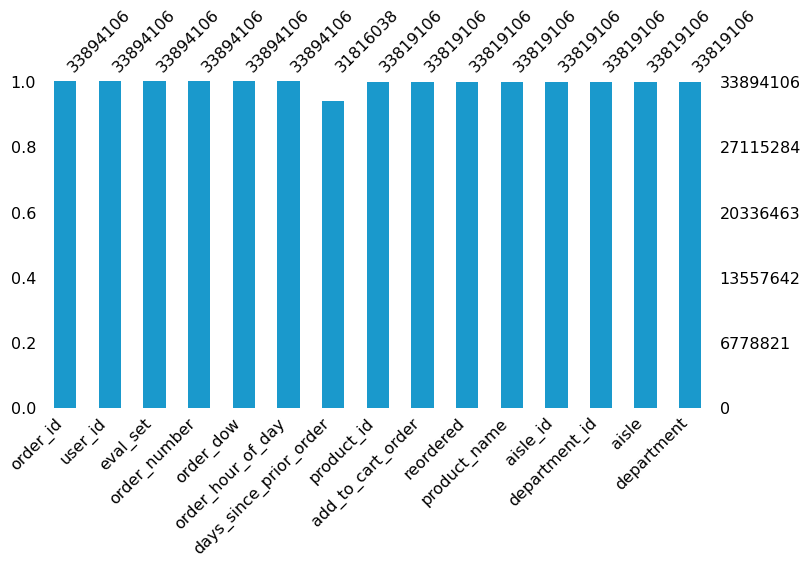

In [5]:
# 결측치 확인
msno.bar(df=total_df.iloc[:,:], color=(0.1,0.6, 0.8), figsize=(12,6))   # total_df
# days_since_prior_order 에서 결측치들이 확인되었습니다. 
# 총 데이터는 15개의 칼럼과 33,894,106개의 행으로 이뤄져 있습니다.

- 결측치 제거 버전 만들기

In [6]:
# 일단 결측치를 제거한 버전과 제거하지 않은 버전으로 나눠 진행하도록 하겠습니다.
oders_df_origin = orders_df.copy()    # 결측치가 남아 있는 버전으로 카피

orders_df = orders_df.dropna()        # 결측치 제거 버전
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0


# 데이터 살펴보기

- <fig. 1>전체적인 데이터의 양과 주문의 종류 파악

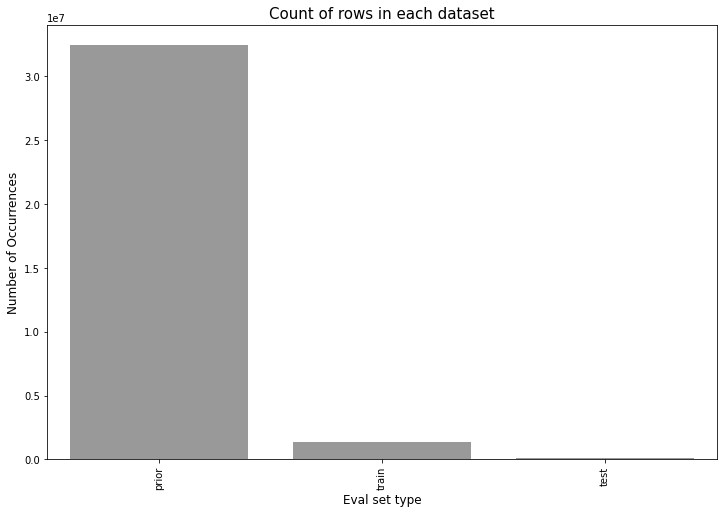

prior    32434489
train     1384617
test        75000
Name: eval_set, dtype: int64


In [7]:
cnt_srs = total_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='gray')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()
print(cnt_srs)

주문(order)는 크게 두 가지로 분류됩니다. 현재의 주문과 과거의 주문.  
현재의 주문은 다시 그 주문 내용이 알려진 train과 케글 대회에서 예측해야 하는 test로 구분됩니다.  
과거의 주문은 모두 prior가 됩니다.  
따라서 prior의 양이 월등히 많고, 현 시점의 주문인 train과 test는 그 양이 적습니다.  
나중에 다시 말씀드리겠지만, 현 데이터는 현재 주문을 한 고객의 과거 1년 주문 데이터를 집계한 것으로 보입니다. 


- 고객의 수

In [8]:
def get_unique_count(x):
  # eval_set 중 고객 id가 몇 개 있는 지 count하는 함수.
  return len(np.unique(x))

cnt_srs = total_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

전체 고객의 수는 206,209 명이며 이 중 현시점의 주문 데이터를 알고 있는 train 고객은 약 13만명, 예측해야 하는 test 고객은 7.5만명입니다.

## 일반주문

- 주문횟수(order_number)   


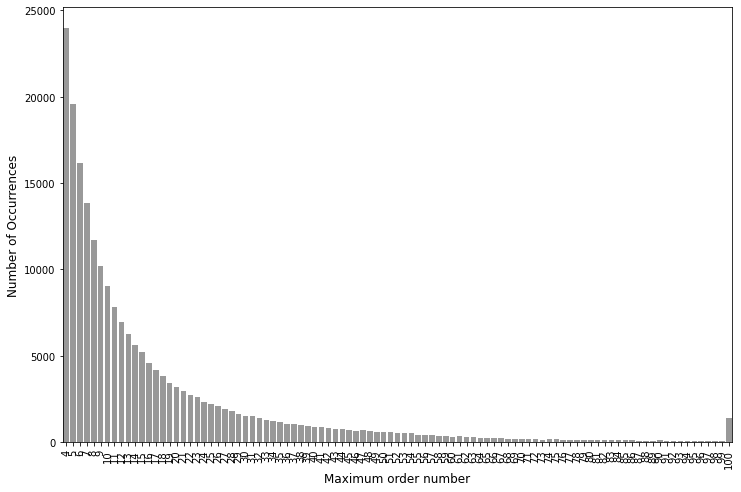

In [9]:
# order_num ; 주문 횟수
cnt_srs = total_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='gray')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

; 'order_number'라고 이름 지어졌지만, 사실 order_frequency에 가깝습니다. 즉, 한 고객이 1년 동안 총 몇 번의 주문을 했는 지를 알 수 있는 지표입니다. 당연히도 대부분의 고객은 1년 동안 20번 이내의 주문을 합니다. 파레토 분포에서도 알 수 있듯 매출을 높이는 고객(주문횟수가 많은 고객)은 소수입니다. 이번 목표는 VIP를 정해 혜택을 주는 것이기에 주문횟수는 VIP를 선정하는 데 있어 중요한 데이터가 될 것으로 보입니다.

- 요일별 주문량

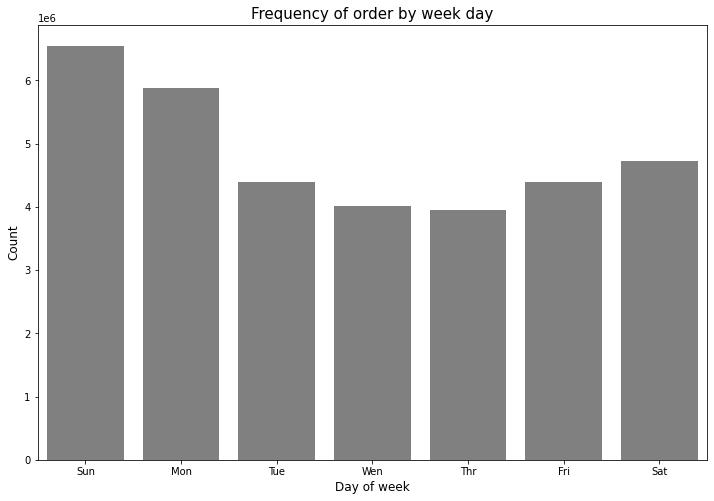

In [10]:
# 요일별 주문량
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=total_df, color='gray')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

여기서 첫번째 칼럼을 '일요일'로 보는 근거는 아래에 '근거'란에서 설명드리겠습니다. 우선 일요일과 월요일에 주문량이 많다는 것에 집중해 보겠습니다. 이는 고객에게 혜택을 줄 때 일요일나 월요일 주문 전에 주는 것이 효과적일 수 있다는 것에 대한 근거가 됩니다.

- <fig. 4> 시간대별 주문량 

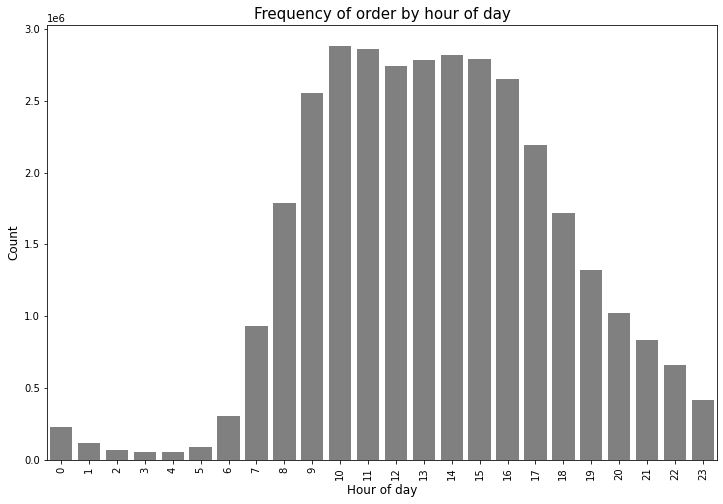

In [11]:
# 시간대별 주문량
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=total_df, color='gray')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

새벽시간에는 주문이 거의 없다가 출근시간과 낮시간에 주문량이 많은 것을 볼 수 있습니다. 가장 많은 시간대는 오전 9시~ 오후 4시 사이입니다. 만약 고객에게 상품 쿠폰을 발행하는 경우 출근시간이나 낮시간이 유효할 수 있습니다. 

- <fig. 5> 시간대, 요일별 주문량

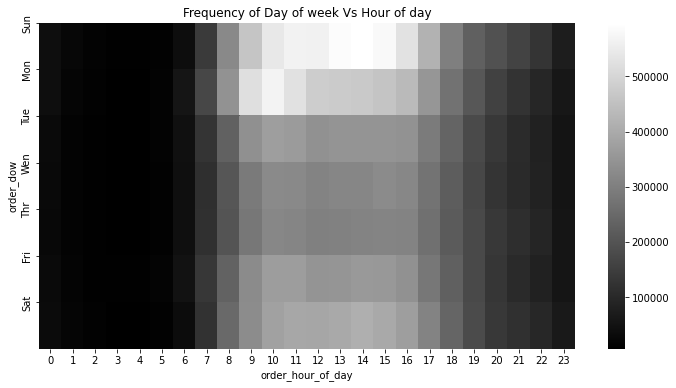

In [12]:
# 시간과 요일별 주문량
grouped_df = total_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

# grouped_df = total_df.groupby(["order_dow", "order_hour_of_day"]).aggregate("count").reset_index()
# grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap= 'gray')
plt.yticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

위 <fig. 3>과 <fig. 4>를 모아 그린 heatmap입니다. 일요일 낮시간과 월요일 오전 출근시간에 주문이 집중된 것을 볼 수 있습니다. 

- <fig. 6> 주문 간격(일)

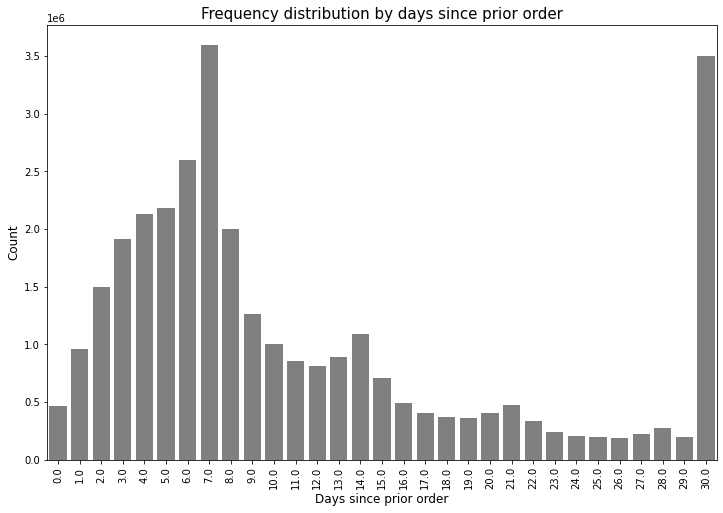

In [13]:
# 주문 간격 (dspo)
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=total_df, color='gray')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

dsop (days_since_prior_order)는 주문 간의 간격을 말합니다. 인스타카트는 식료품 판매 플랫폼이기 때문에 일주일 간격으로 주문을 하는 사람들이 많습니다. 특이한 점은 30일 간격 주문이 갑자기 급증한다는 것입니다. 한달 단위로 주문하는 사람이 많다는 말이기도 하지만 뭔가 이상합니다. 확인해 볼 필요가 있습니다.

- 재주문율

In [14]:
# percentage of re-orders
print(total_df.reordered.sum() / total_df.shape[0])                    # 전체 주문 대비 재주문 비율
grouped_df = total_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
print(grouped_df.reordered.value_counts() / grouped_df.shape[0])       # 이전 재주문 경험이 있을 경우 재주문 할 비율

0.5887560509783029
1.0    0.861998
0.0    0.138002
Name: reordered, dtype: float64


전체 재주문 비율은 약 60%로 매우 높은 편에 속합니다. 서비스의 품질이 좋다는 이야기이고 향후 발전 가능성이 높다는 이야기. 특히 재주문 경험이 있는 고객의 경우에는 무려 86%가 재주문을 하고 있습니다. VIP 혜택의 경우에도 자주 주문하는 상품을 추천해 주는 것이 좋을 것으로 보입니다.

- 장바구니 상품 수와 주문량

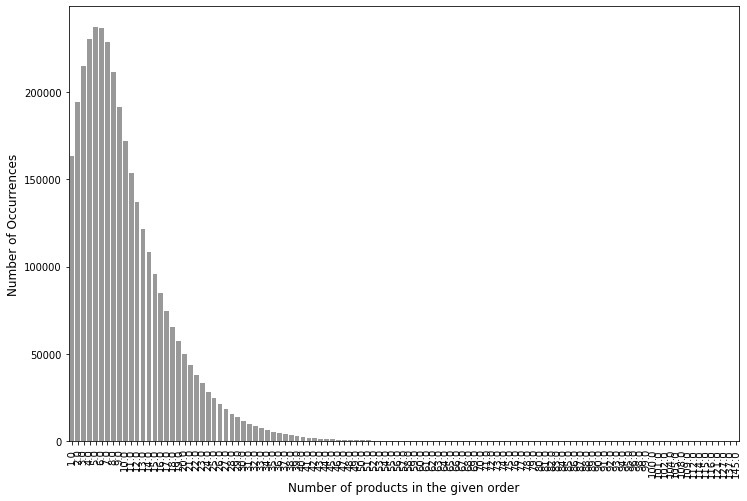

In [15]:
grouped_df = total_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='gray')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

한번에 주문하는 장바구니 상품의 수는 대부분 3~8개 내외에 집중돼 있습니다.VIP 고객에 제공하는 쿠폰 갯수도 한 번에 5개 정도로 하는 것이 좋아 보입니다.

- 가장 많이 주문하는 상품

In [16]:
cnt_srs = total_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


고객이 가장 많이 주문하는 상품 20개를 나타냅니다. 1위는 바나나이고 20위 안에는 주로 신선과일이나 야채 등입니다. 고객 혜택으로 가장 선호할 상품은 신선과일이나 야채가 좋을 것 같습니다.

- 소분류(aisle)와 주문 수

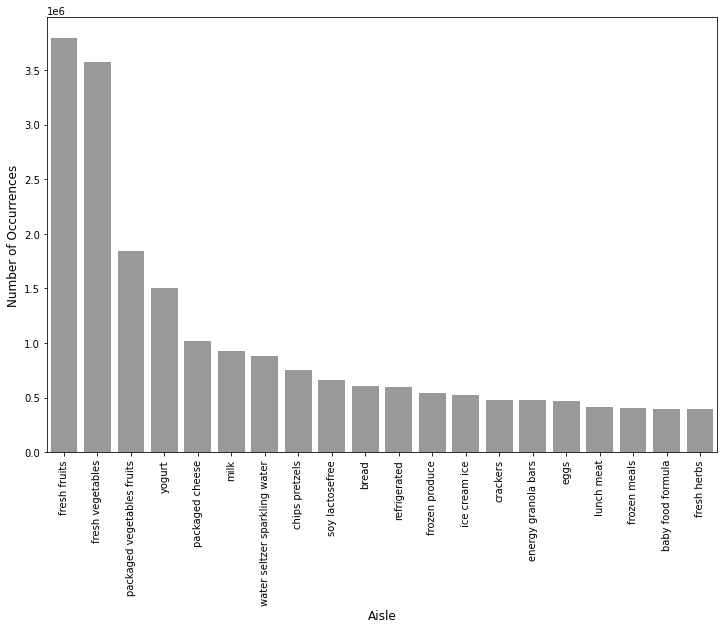

In [17]:
# 소분류(aisle)
cnt_srs = total_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='gray')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

소분류에서도 신선과일과 야채가 1위를 차지하고 있습니다.

- 대분류(department)와 주문 수

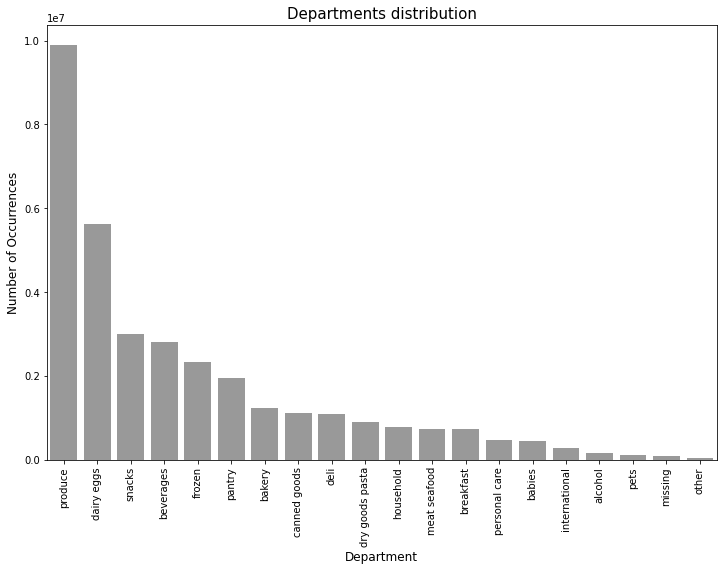

In [18]:
# 대분류(department)
cnt_srs = total_df['department'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='gray')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Departments distribution", fontsize=15)

plt.show()

대분류에서도 가장 선호하는 상품은 produce(농산물)입니다.  

## 재 주문

- 재주문 상품의 대분류

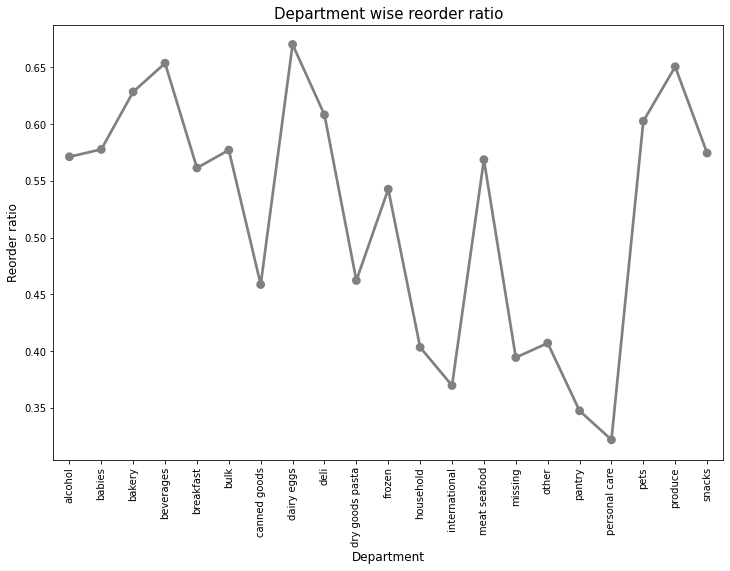

In [19]:
grouped_df = total_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color='gray')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

이번엔 재주문율로 살펴보겠습니다. 대분류 중 재주문이 많은 상품군은 농산품과 달걀 관련 상품입니다.

- 재주문률과 상품의 분류

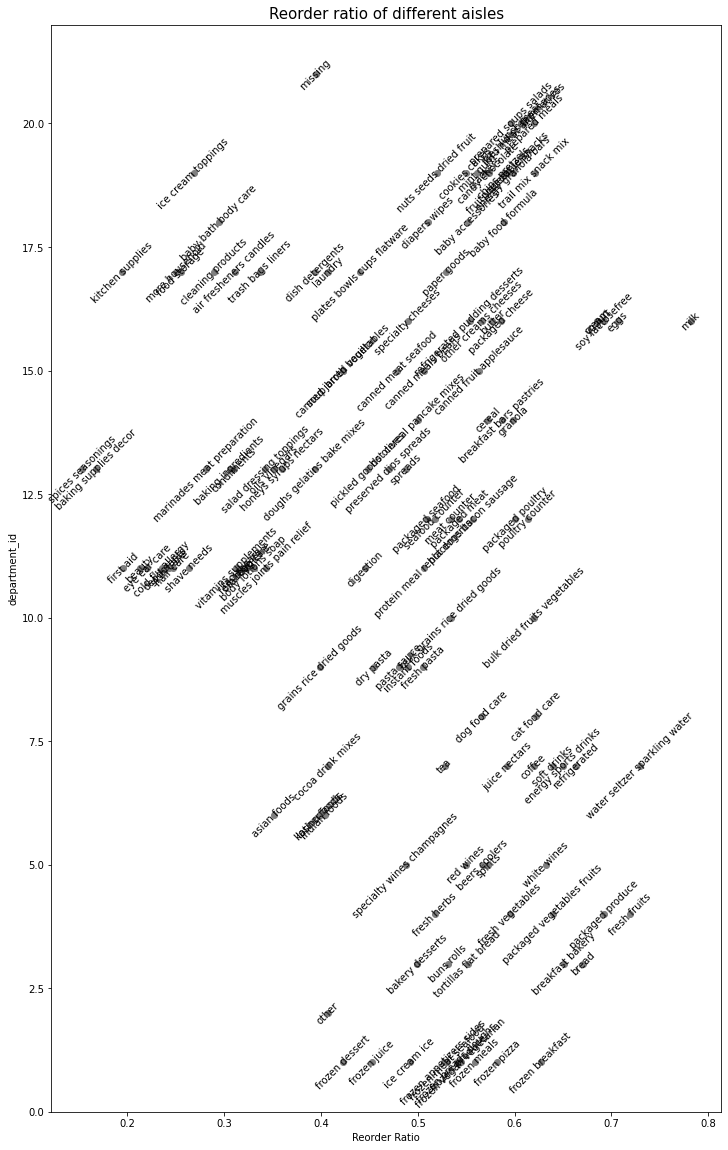

In [20]:
grouped_df = total_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values, color='gray')
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='black')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

소분류와 함께 살펴보면, 재주문율이 높은 상품은 우유, 과일, 스파클링 워터 등이 있음을 알 수 있습니다. 

- 장바구니 수와 재주문율

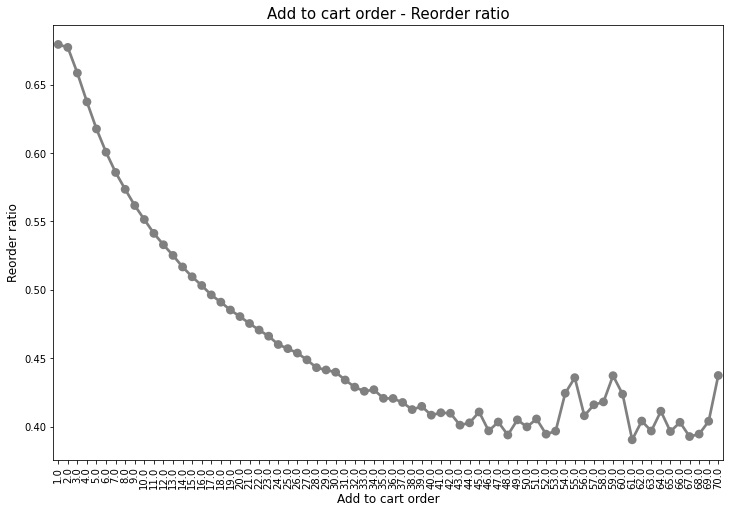

In [21]:
# 장바구니 수와 재주문률
total_df["add_to_cart_order_mod"] = total_df["add_to_cart_order"].copy()
total_df["add_to_cart_order_mod"].iloc[total_df["add_to_cart_order_mod"]>70] = 70             # max가 145이므로 70 이상은 70으로 가정
grouped_df = total_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()  # 평균 재주문률

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color='gray')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

재주문이 많은 특이한 경우는 장바구니 개수가 50~60개 구간에 있습니다. 이 구간의 고객을 살펴볼 필요가 있습니다.

- 요일별 재주문율

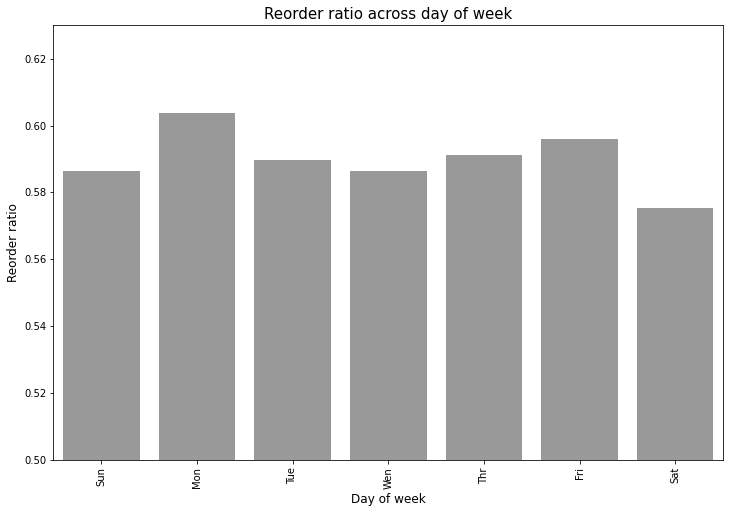

In [22]:
grouped_df = total_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color='gray')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.63)
plt.show()

요일별 재주문율을 살펴보면 월요일과 금요일이 상대적으로 높지만, 재주문이 아닌 일반 주문처럼 다른요일과 큰 차이를 보이지는 않습니다.

- 시간대별 재주문율

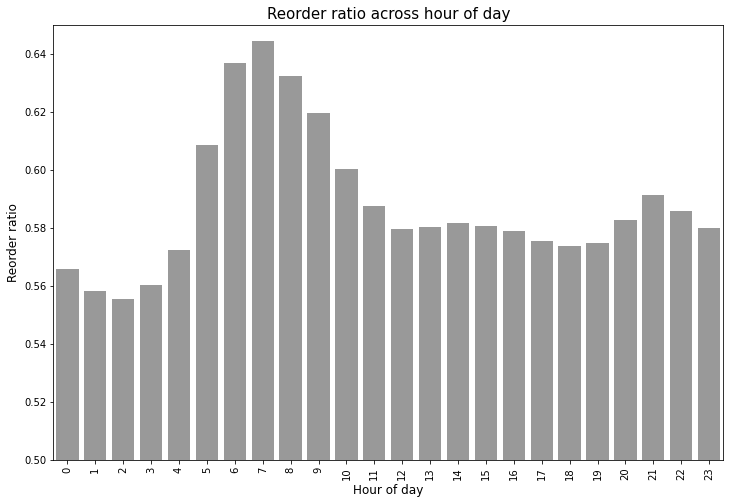

In [23]:
grouped_df = total_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color='gray')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.65)
plt.show()

시간대별로 살펴보면, 재주문율이 높은 시간대는 아침 새벽과 출근시간입니다. 밤 9시 전후에도 재주문율이 높음을 알 수 있습니다.

- 요일과 시간대별 재주문율

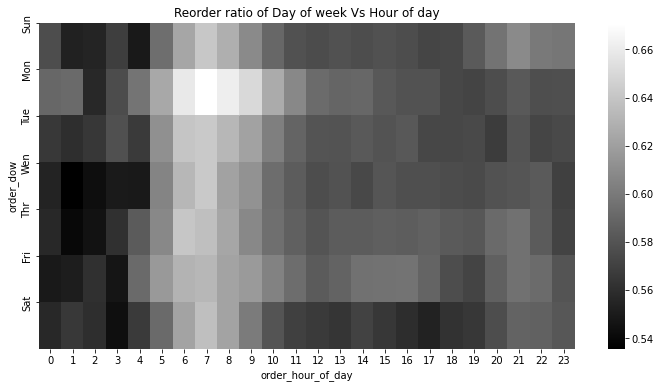

In [24]:
grouped_df = total_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap='gray')
plt.yticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

요일과 시간대별 재주문율의 heatmap입니다. 아침 시간대 특히 월요일 아침에 재주문율이 높음을 알 수 있습니다.  
정리하면, 자주 주문하는 물품의 경우 재주문율이 높고 시간대는 월요일 아침일 가능성이 높습니다. VIP 고객의 경우, 재주문을 많이 할 것으로 예상되며 만약 VIP에게 상품을 추천하거나 혜택을 준다면 재주문율이 높은 상품의 자주 주문하는 시간대에 하는 것이 효과적일 것으로 보입니다.

# 홍보팀 제안 사항

## 누구에게 무엇을 언제? 그리고 왜?

- 저희 프로젝트의 목적은 인스타카트 매출 향상을 위한 홍보 전략을 세우는데 있어 고객 데이터를 분석해 홍보팀에 도움을 주는 데 있습니다.
- 구체적으로는 고객 정보를 이용해 VIP(who)를 구분하고 이들에계 상품 혜택(what)을 줄 적절한 시기(when)를 제안하는 것입니다.  

## **VIP Clustering**(Who?)

VIP는 우리 회사의 매출 향상에 큰 도움을 주는 고객입니다. 즉, 우리 서비스를 통해 주문을 꾸준히, 빈번하게 많이 하는 고객일 것입니다.  

주어진 데이터를 이용해 다음과 같이 Clustering 하겠습니다.
- 꾸준히
- 빈번히
- 많이  

구매하는 고객을 구분하고 이들을 VIP라 정의하도록 하겠습니다.  
VIP 선정 기준은 각 클러스터의 구성원이 전체 고객의 10% 내외가 되도록 조절하겠습니다.

* GGUZUNI(꾸준히)

In [25]:
gguzuni_series = orders_df.groupby('user_id')['days_since_prior_order'].sum()
gguzuni_series
gguzuni_series.max()                             # 365일 내내 주문 한 사람이 max.
gguzuni_series.mean() + 2* gguzuni_series.std()  # 
gguzuni_user_id =[]
longterm_limit = 340                             # 20만명의 10% = 2만명 내외가 되도록 조절
for i, val in enumerate(gguzuni_series):
  if val >= longterm_limit:
    # print(i)
    gguzuni_user_id.append(i)
len(gguzuni_user_id)                              #19602

'''
우선, 이 데이터 셋의 집계 최대치는 1년입니다. 
이것을 알 수 있는 이유는 dspo(주문간격)의 총 합이 365일을 넘지 않기 때문입니다.  
꾸준히 주문했다는 말은 주문 간격을 모두 더했을때 그 합이 365에 가깝다는 것을 의미합니다. 
즉, 고객의 10%인 2만명 내외가 되도록 dspo가 340 이상인 고객을 VIP_GGUZUNI로 정의 했습니다.
'''

'\n우선, 이 데이터 셋의 집계 최대치는 1년입니다. \n이것을 알 수 있는 이유는 dspo(주문간격)의 총 합이 365일을 넘지 않기 때문입니다.  \n꾸준히 주문했다는 말은 주문 간격을 모두 더했을때 그 합이 365에 가깝다는 것을 의미합니다. \n즉, 고객의 10%인 2만명 내외가 되도록 dspo가 340 이상인 고객을 VIP_GGUZUNI로 정의 했습니다.\n'

- BINBUNI (빈번히)

In [26]:
binbuni_series = orders_df.groupby('user_id')['order_number'].max()
binbuni_series
binbuni_series.max()                              # 100번 주문 한 사람이 최고.
binbuni_series.mean() + 2* binbuni_series.std()
binbuni_user_id =[]
freq_limit = 39                                   # 20만명의 10% = 2만명 내외가 되도록 조절
for i, val in enumerate(binbuni_series):
  if val >= freq_limit:
    # print(i)
    binbuni_user_id.append(i)
len(binbuni_user_id)                               # 19,684

'''
빈번한 거래를 하는 고객도 VIP 자격이 있습니다. 
주어진 데이터 셋에서 빈도의 최대값은 100입니다. 
따라서 100 이하의 주문 빈도를 가진 고객 중 10%인 2만명 내외가 되도록 limit을 39로 정했습니다.
'''

'\n빈번한 거래를 하는 고객도 VIP 자격이 있습니다. \n주어진 데이터 셋에서 빈도의 최대값은 100입니다. \n따라서 100 이하의 주문 빈도를 가진 고객 중 10%인 2만명 내외가 되도록 limit을 39로 정했습니다.\n'

- MANI (많이)

In [27]:
mani_series = total_df.groupby('user_id')['eval_set'].count()
mani_series
mani_series.max()                              # 3,726 개를 주문 한 사람이 최고.
mani_series.mean() + 2* mani_series.std()
mani_user_id =[]
products_limit = 400                           # 20만명의 10% = 2만명 내외가 되도록 조절
for i, val in enumerate(mani_series):
  if val >= products_limit:
    # print(i)
    mani_user_id.append(i)
len(mani_user_id)                              # 20,316 명

'''
상품을 많이 주문한 고객도 VIP 자격이 있습니다. 
총 3726개의 상품을 주문한 고객이 최다 구매자입니다. 
이 숫자 이하에서 10%인 2만명 내외가 되도록 400개 이상으로 VIP 제한을 두겠습니다.
'''

'\n상품을 많이 주문한 고객도 VIP 자격이 있습니다. \n총 3726개의 상품을 주문한 고객이 최다 구매자입니다. \n이 숫자 이하에서 10%인 2만명 내외가 되도록 400개 이상으로 VIP 제한을 두겠습니다.\n'

- 벤 다이어 그램

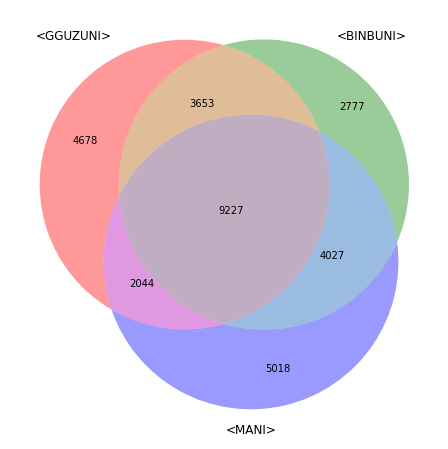

VIP 총 합 :  31424


'\n벤 다이어 그램을 살펴보면 VIP의 총 합은 31,424명이고 세 클라스터에 모두 포함되는 고객이 약 9600명임을 알 수 있습니다.\n\n'

In [28]:
from matplotlib_venn  import venn3, venn3_circles, venn3_unweighted
import matplotlib.pyplot as plt
import random

set1 = set(gguzuni_user_id)
set2 = set(binbuni_user_id)
set3 = set(mani_user_id)

fig = plt.figure(figsize=(16,8))

ven_plot = venn3([set1,set2,set3], set_labels=('<GGUZUNI>','<BINBUNI>','<MANI>'))
plt.show(ven_plot)

all = set1|set2|set3
print('VIP 총 합 : ', len(all))                   # VIP의 수 : 31,424 명  

'''
벤 다이어 그램을 살펴보면 VIP의 총 합은 31,424명이고 세 클라스터에 모두 포함되는 고객이 약 9600명임을 알 수 있습니다.

'''

## 어떤 상품을 좋아할까? (What?)

<function matplotlib.pyplot.show(*args, **kw)>

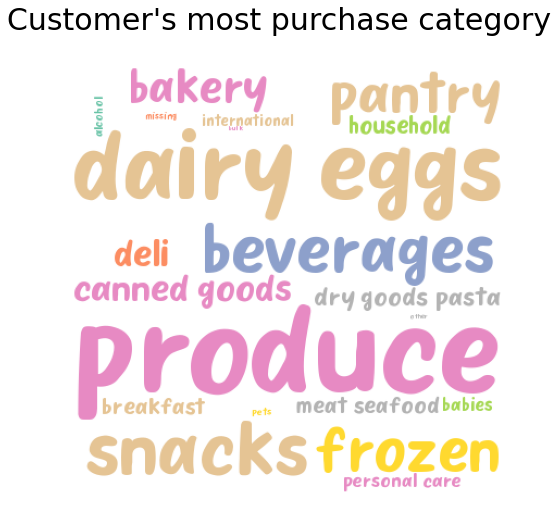

In [54]:
customer_max_buy_category = total_df['department'].value_counts().reset_index() 
customer_max_buy_category.columns = ['product_name', 'f_count']

department_rank = customer_max_buy_category.set_index("product_name").to_dict()["f_count"]

wordcloud = WordCloud(
    #font_path = "/content/drive/MyDrive/Galmuri9.ttf",        #해당 폰트가 경로에 없으면 주석해야함
    font_path = "/content/drive/MyDrive/Colab Notebooks/dataton/etc/Room No.703.ttf",
    width =400,
    height = 400,
    random_state=10,
    colormap='Set2', 
    max_font_size= 500,
    background_color = 'white',
).generate_from_frequencies(department_rank)


plt.figure(figsize=(8,8))
plt.suptitle('Customer\'s most purchase category', fontsize = 30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show


고객이 가장 많이 구매하는 카테고리는 

농산물, 달걀, 스낵, 음료 순서입니다.

구체적으로 VIP들은 어떤 상품군을 좋아할까요? 

- GGUZUNI

<function matplotlib.pyplot.show(*args, **kw)>

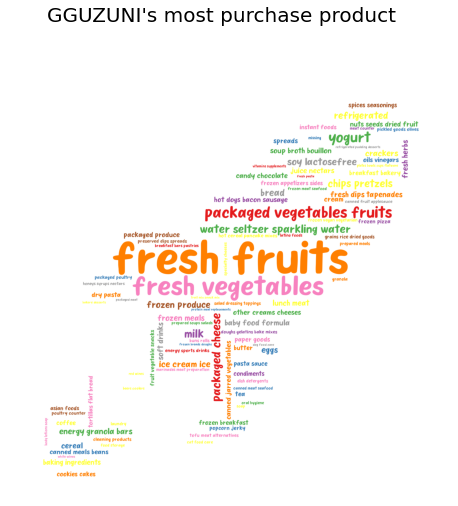

In [30]:
gguzuni_df = pd.DataFrame(gguzuni_user_id, columns=['user_id'])

wordcloud = wc(gguzuni_df,gguzuni_user_id,1)

plt.figure(figsize=(8,8))
plt.suptitle('GGUZUNI\'s most purchase product', fontsize = 20)

plt.imshow(wordcloud)

plt.axis('off')
plt.show

- BINBUNI

<function matplotlib.pyplot.show(*args, **kw)>

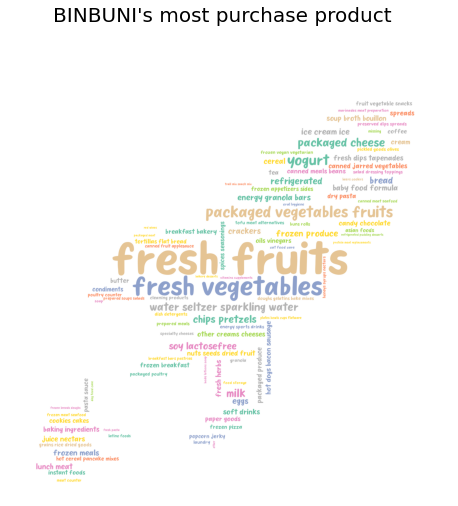

In [31]:
binbuni_df = pd.DataFrame(binbuni_user_id, columns=['user_id'])

wordcloud = wc(binbuni_df,binbuni_user_id,2)

plt.figure(figsize=(8,8))
plt.suptitle('BINBUNI\'s most purchase product', fontsize = 20)

plt.imshow(wordcloud)
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

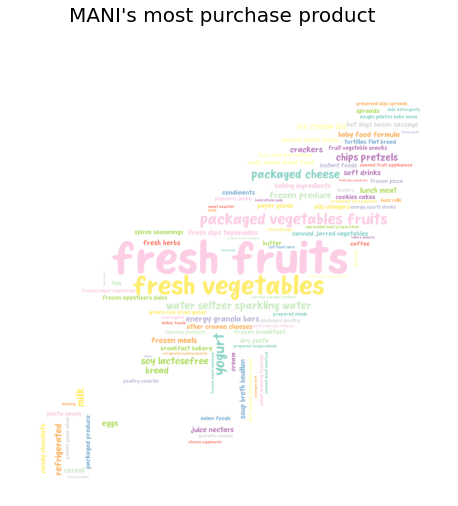

In [32]:
mani_df = pd.DataFrame(mani_user_id, columns=['user_id'])

wordcloud = wc(mani_df,mani_user_id,3)

plt.figure(figsize=(8,8))
plt.suptitle('MANI\'s most purchase product', fontsize = 20)

plt.imshow(wordcloud)
plt.axis('off')
plt.show

세 클라스터 모두 'Fresh Fruits' 또는 'Fresh vegetables' 를 좋아합니다.  
따라서, 상품 혜택은 이 두 소그룹에서 선택하는 것이 좋겠습니다.  

구체적인 상품으로는

             product_name  frequency_count
0                  Banana           491291
1  Bag of Organic Bananas           394930
2    Organic Strawberries           275577
3    Organic Baby Spinach           251705
4    Organic Hass Avocado           220877
5         Organic Avocado           184224
6             Large Lemon           160792
7            Strawberries           149445
8                   Limes           146660
9      Organic Whole Milk           142813


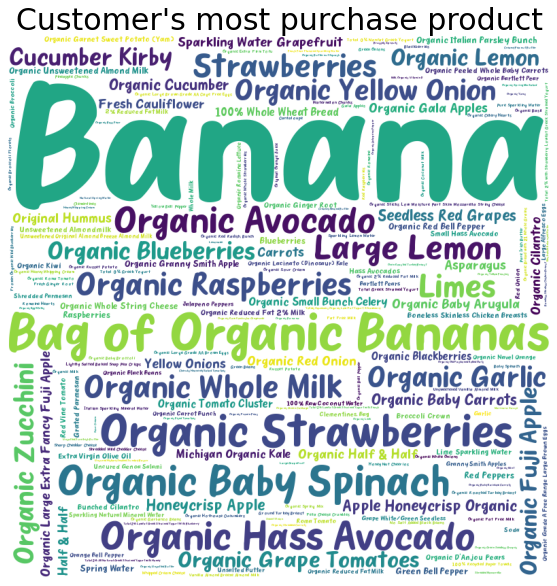

In [35]:
customer_max_buy = total_df['product_name'].value_counts().reset_index()
customer_max_buy.columns = ['product_name', 'frequency_count']
#type(customer_max_buy)
print(customer_max_buy.head(10))

order_rank = customer_max_buy.set_index("product_name").to_dict()["frequency_count"]

wordcloud = WordCloud(
    #font_path = "/content/drive/MyDrive/Galmuri9.ttf",        #해당 폰트가 경로에 없으면 주석해야함
    font_path = '/content/drive/MyDrive/Colab Notebooks/dataton/etc/Room No.703.ttf',
    width =800,
    height = 800,
    max_font_size= 300,
    background_color = 'white'
).generate_from_frequencies(order_rank)


plt.figure(figsize=(10,10))
plt.title('Customer\'s most purchase product', fontsize = 30)
plt.suptitle("")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



바나나, 딸기, 시금치, 아보카도 등 할인 쿠폰이 좋을 수 있겠습니다.

## **언제 주면 좋을까? (When?)**

앞에서 살펴 봤듯이 주문이 많은 요일과 시간은 일요일, 월요일 낮시간입니다.

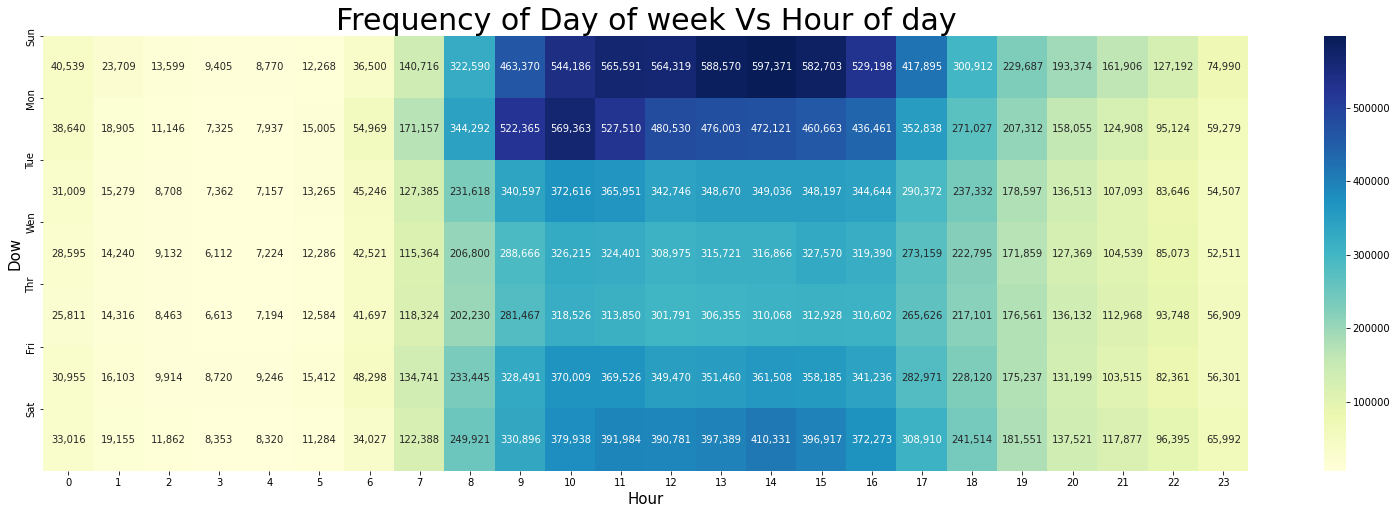

In [36]:
grouped_df = total_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(27,8))
#annot(annotate each cell with numeric value)/ fmd='d'(정수형태integer format)숫자를 입력하라는 뜻/ 

sns.heatmap(grouped_df, annot=True, fmt=",.0f", cmap="YlGnBu")
plt.title("Frequency of Day of week Vs Hour of day", fontsize=30)
plt.yticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])

plt.xlabel("Hour" ,fontsize=15)
plt.ylabel("Dow" ,fontsize=15)

plt.show()


# plt.figure(figsize=(10,10))
# sns.swarmplot(x='order_hour_of_day', y='order_number', data=grouped_df1)

주문하는 주기는 주로 1주일 단위입니다.

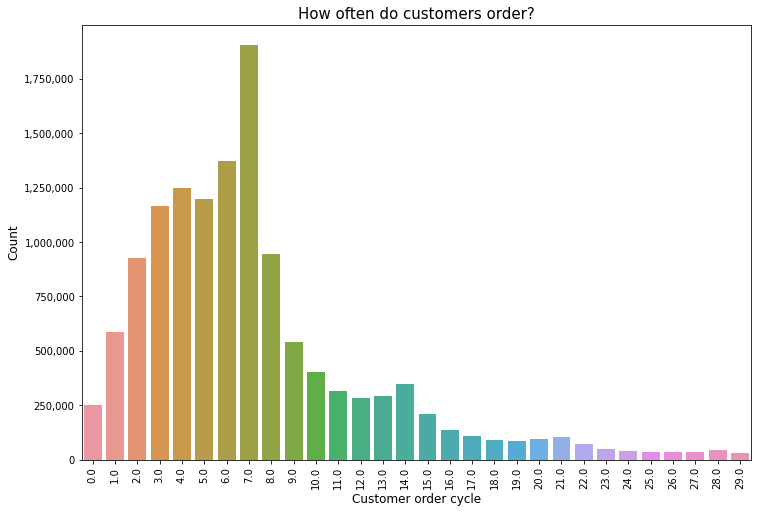

In [37]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=no_30(total_df))        # dspo 30을 제외한 그래프

plt.xlabel('Customer order cycle', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation='vertical')
current_values= plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.title("How often do customers order?", fontsize=15)
plt.show()

VIP의 경우 재주문율이 더 중요할 수 있습니다.  
재주문율의 경우 월요일 출근시간에 높아집니다.

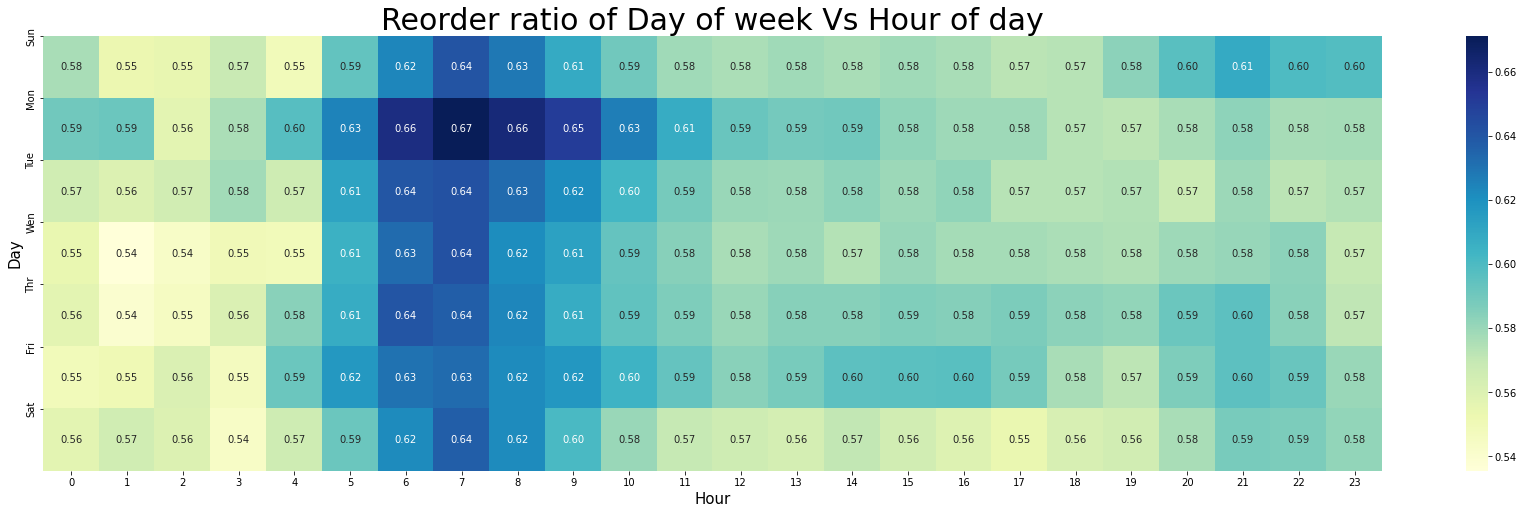

In [38]:
grouped_df = total_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(30,8))

sns.heatmap(grouped_df, annot=True, fmt=".2f",cmap="YlGnBu")
plt.title("Reorder ratio of Day of week Vs Hour of day", fontsize=30)
plt.yticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])

plt.xlabel("Hour" ,fontsize=15)
plt.ylabel("Day" ,fontsize=15)
plt.show()

## 참고 : 얼마나 주면 될까?

한번에 결제하는 장바구니 물품 수는 최빈값은 3~8 사이입니다.  
따라서, 그 사이의 물품 가격을 적절히 예측하여 주는 것도 나쁘지 않아 보입니다.

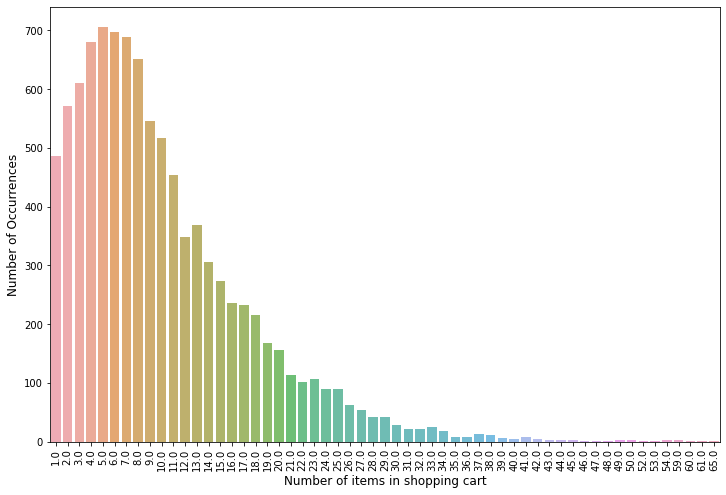

In [39]:
grouped_df = total_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index().head(10000)
graph = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(graph.index, graph.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of items in shopping cart', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## **결론**

- 누구에게 : 꾸준히 빈번하게 많이 구매한 VIP 고객에게
- 무엇을 : Fresh fruit 또는 Fresh vegetables 주문에 대한 혜택을
- 언제 : 재주문이나 주문 건수가 가장 많은 월요일 오전이 되기 전에  
쿠폰을 제공하는 것이 데이터를 근거로 했을 때 가장 효과적일 것으로 보입니다.


# =======================================



# 근거 (Why) 

### 1. 'order_dow'에서 '0'은 일요일이다.

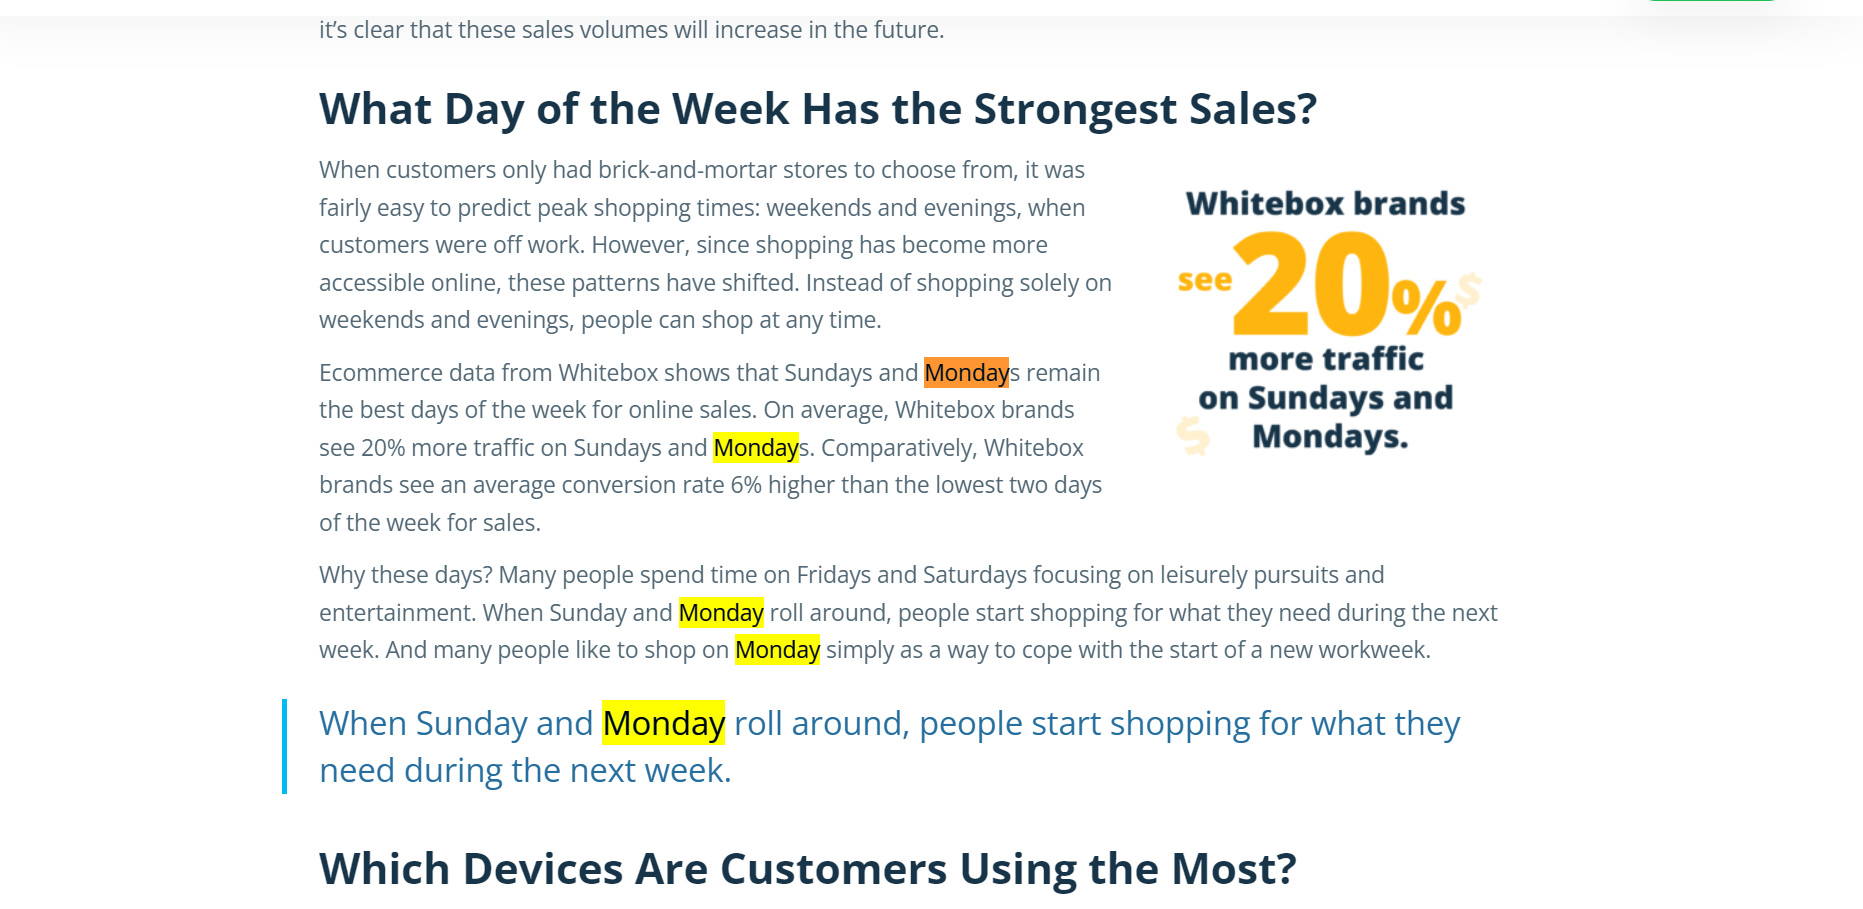

https://whitebox.com/blog/best-days-of-the-week-to-sell-online/

![image.png]()

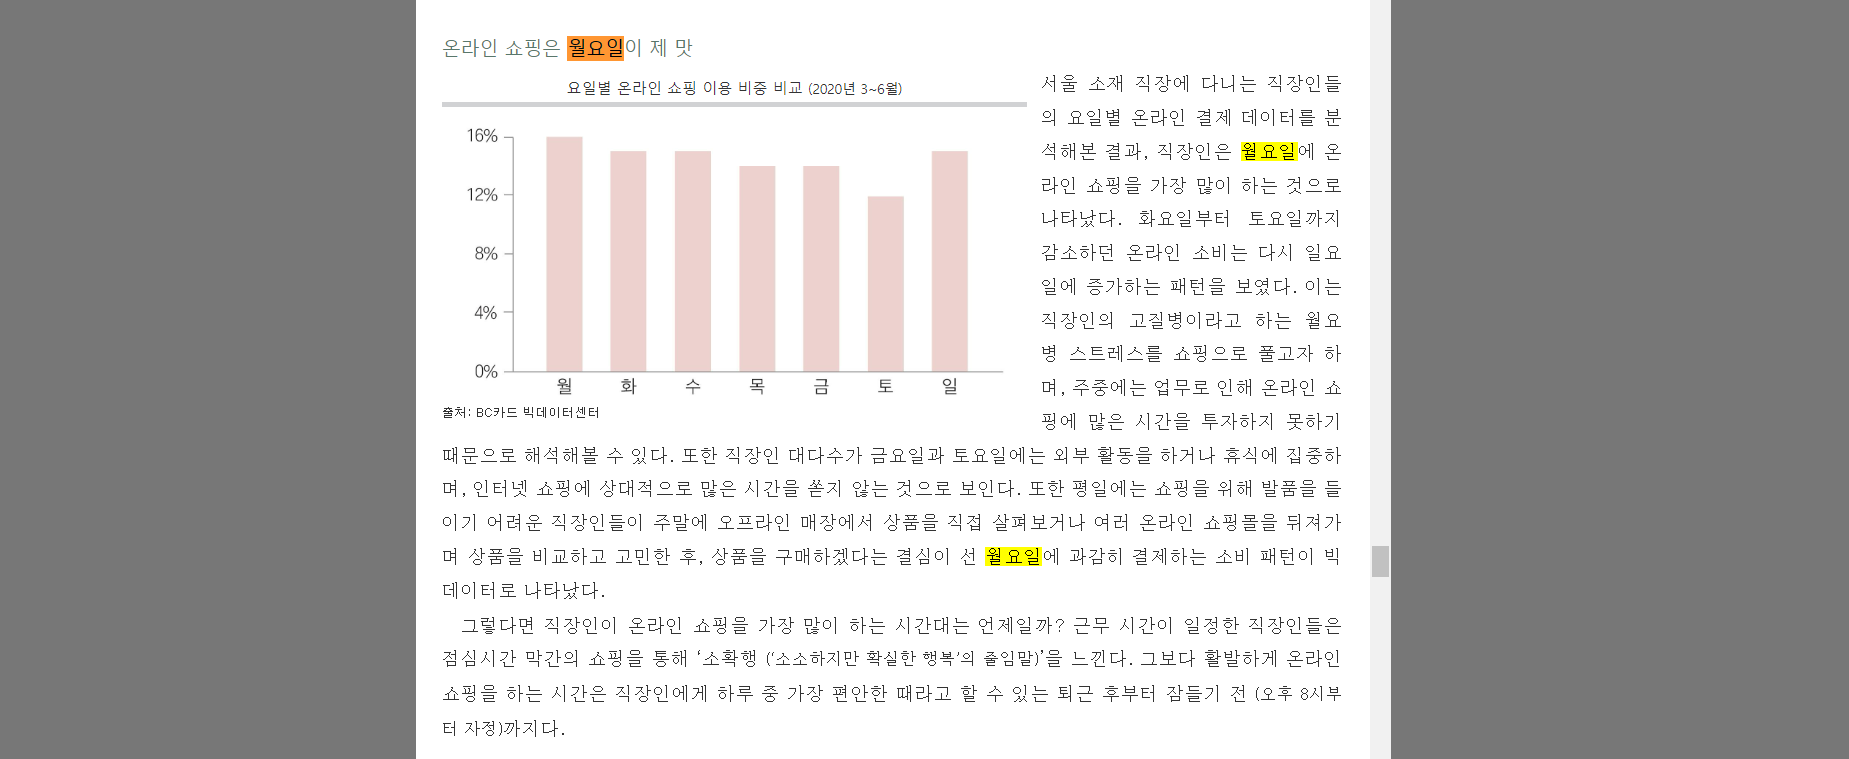

http://preview.kyobobook.co.kr/epubPreviewPopup.jsp?type=web&barcode=4801197293406&search=Y&orderClick=LAT

위 두 글에서 볼수 있듯이 월요일은 온라인 쇼핑에서 매출이 많이 발생하는 요일입니다. 따라서, 다음 그래프에서 첫번째와 두번째는 일요일과 월요일일 가능성이 매우 높습니다.

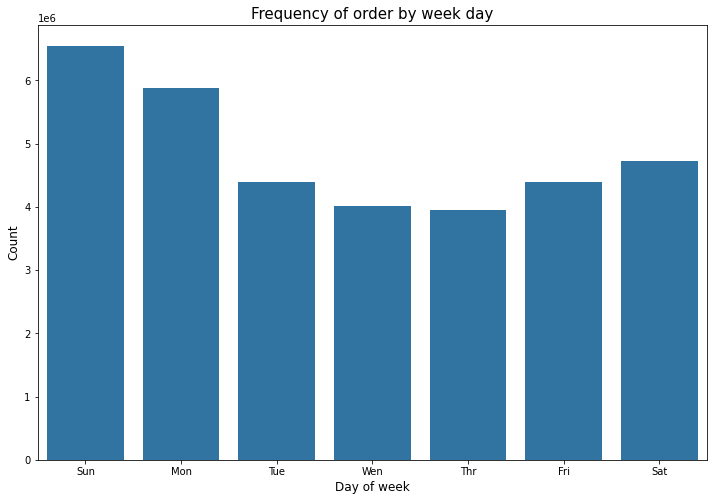

In [40]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=total_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wen','Thr','Fri','Sat'])
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

### 2. 주문간격(days_since_prior_order) 30일은 믿을 수 있는 데이터가 아니다.

이를 판단할 수 있는 로직은 다음과 같습니다.  
dspo(주문간격)이 30일인 어떤 주문이 있다고 가정하겠습니다.  
이 주문은 30일 이후 이뤄졌으므로, 이전 주문은 현재 요일에서 2를 뺀 값과
같아야 합니다.  
예를들면, 목요일 주문이 있는데 이전 주문이 30일 전이라면 2를 뺀 화요일이어야 합니다.  

만약, 화요일이 아니라면 그 30은 잘못된 값이 됩니다. 

In [41]:
temp = []
comp = 0
count = 0
total = 0

for i, line in enumerate(total_df['days_since_prior_order']):
    # print(count)
    if line == 30:
        # print(i, line)
        total += 1
        comp = (total_df.loc[i,'days_since_prior_order'] - total_df.loc[i-1,'days_since_prior_order']) % 7
        if comp != 2:
            count += 1
            
    temp = line

print("total number of '30 day since prior order' = "+ str(total))
print("total number of false result = " + str(count))

total number of '30 day since prior order' = 3500389
total number of false result = 3454844


In [42]:
3454844/3500389

0.9869885889825388

이런 로직에 의해 구한 오류율(dspo가 30일이 아닌 비율)은 무려 98.7%나 됩니다.  

따라서, 다음 그래프에서 30의 값은 믿을 수 없는 값입니다.

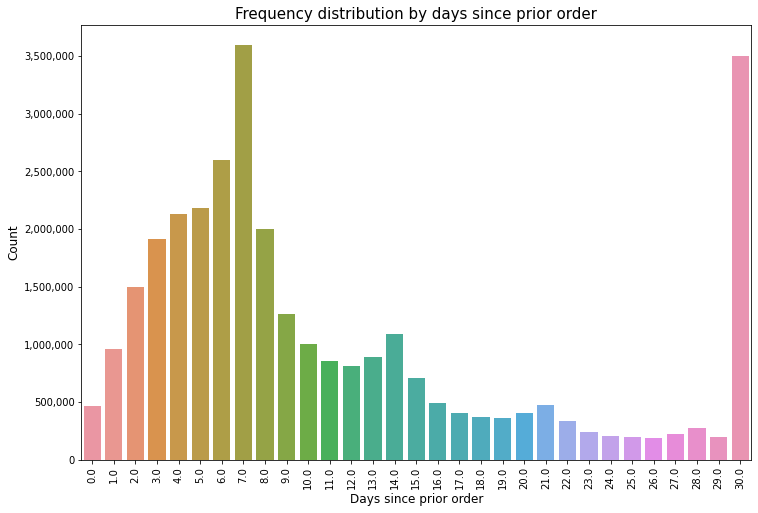

In [43]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=total_df,)    # 여기가 원래는 orders_df인데 total_df 가 맞을지?

plt.xlabel('Days since prior order', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation='vertical')
current_values= plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])



plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

### 3. 장바구니 수와 주문수 그래프에서 50~60 사이 고객은 VIP와 관련 없다. 

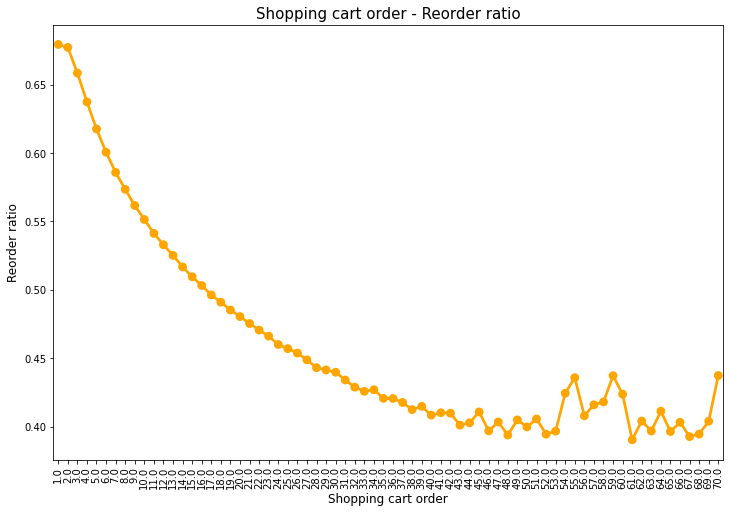

In [44]:
total_df["add_to_cart_order_mod"] = total_df["add_to_cart_order"].copy()
total_df["add_to_cart_order_mod"].loc[total_df["add_to_cart_order_mod"]>70] = 70
grouped_df = total_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color='orange')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Shopping cart order', fontsize=12)
plt.title("Shopping cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')

plt.show()

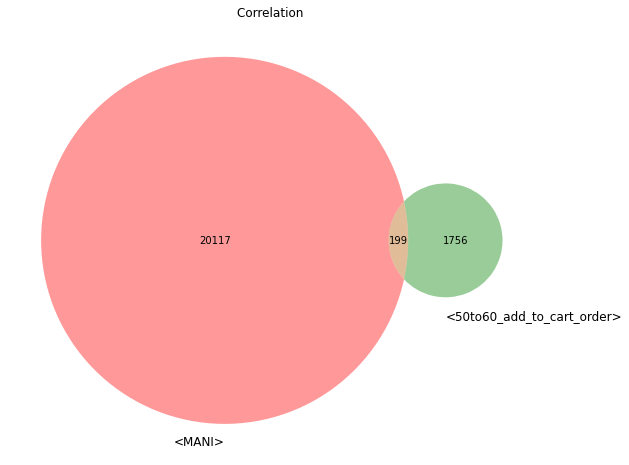

In [45]:
# 벤다이어 그램으로 그려보기 
# MANI와 얼마나 겹치는 지 ; 이 고객들이 VIP에 포함 되는가?
from matplotlib_venn  import venn2

a = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/dataton/more_than_50_add_to_cart_order.pkl')
a_set=a.drop_duplicates('user_id')
a_list = list(a_set['user_id'])

set1 = set(mani_user_id)
set2 = set(a_list)

fig = plt.figure(figsize=(16,8))

ven_plot = venn2([set1, set2], set_labels=('<MANI>','<50to60_add_to_cart_order>'))
plt.title('Correlation ')

plt.show(ven_plot)

벤다이어그램에서 많이 구매한 고객과 겹치는 부분이 미미하다. 만약 VIP였다면 아마도 거의 부분집합 정도가 되어야 할 것이다.

### VIP 선정 시 10%의 근거

VIP로 선정된 31,424 명의 고객은 전체 고객 206,209명의 약 15%입니다.


In [46]:
31424/206209

0.15238908098094653

또한 이들이 사는 물품의 수는 40.5%에 달합니다. 이 15%에게 혜택을 주는 것은 홍보효과로 충분한 가치가 있다고 판단했습니다. 

In [47]:
vip_id = list(set1|set2|set3)

vip_series = total_df.groupby('user_id')['eval_set'].count()
vip_products = 0
for i, val in enumerate(vip_series):
  if i in vip_id:
    # print(i)
    vip_products += val
vip_products/len(total_df)                             


0.4055150178618076

# 한걸음 더 나아가기

### 시계열

고객 정보를 시계열 자료로 바꿔 보겠습니다.  
근거는 dspo입니다. 즉, 이전 주문과의 간격이 있고 이를 더해서 누적하면 시계열을 구할 수 있지 않을까 하는 생각에서 출발합니다.

In [76]:
# dspo 30과 te가 없는 df 만들기
no_30_df = no_30(orders_df)     # 이렇게 하는 이유는 30일 간격이 믿을 수 없는 데이터이기 때문입니다. 

In [77]:
# user_id_no_30 를 list로 두기
user_id_no_30 = user_id_list(no_30_df)
len(user_id_no_30)

54197

In [79]:
# orders_df 에서 user_id_no_30 에 해당하는 dspo 리스트 받아서 합 구하기
dspo_sum_no_30 = no_30_df.groupby('user_id')['days_since_prior_order'].sum()
len(dspo_sum_no_30)

# len(dspo_sum)          # dspo 30  없는 고객 54,197 명
# max(dspo_sum)          # dspo의 합 365 일
# print(users_id[0:10])
# print(dspo_sum[0:10])

54197

In [84]:
# 이용기간이 가장 긴 고객(dspo==365일)의 id를 리스트로 받기

dspo_series = orders_df.groupby('user_id')['days_since_prior_order'].sum()
longterm_user_id =[]
longterm_limit = 365                             
for i, val in enumerate(dspo_series):
  if val >= longterm_limit:
    # print(i)
    longterm_user_id.append(i)
len(longterm_user_id)                              

1568

In [85]:
# 자 그럼 검증을 해볼까? dspo==365인 사람들의 dow 마지막 값이 같을까??
longterm_user_tr_dow =[]
for id in longterm_user_id:
  a = mk_list(id,'order_dow')
  print(a[-1], end=' ')
  longterm_user_tr_dow.append(a[-1])

# ㅠㅠ 다르네요. 이것이 의미하는 것은 tr 발생 시점이 하루가 아니라는 말이며, 일주일 단위로 으로 집계된 자료라는 의미


2 0 1 5 4 0 3 0 4 0 1 0 0 6 0 5 2 4 0 0 0 2 0 6 4 1 5 6 2 6 0 4 2 2 0 2 4 6 0 0 6 4 6 5 6 2 2 2 2 1 3 0 4 2 2 3 1 5 6 4 4 2 2 2 0 6 1 0 0 5 0 0 0 6 5 6 4 5 3 0 2 3 3 3 0 3 1 2 0 6 1 0 6 3 2 3 6 0 3 6 3 3 0 1 3 5 1 3 4 2 1 2 6 1 1 4 5 3 1 5 0 0 1 3 1 1 4 3 5 3 0 4 4 0 0 5 0 3 5 2 1 5 2 0 2 0 1 0 6 1 2 3 5 5 5 2 0 2 1 0 0 4 5 5 5 5 0 5 6 1 5 0 2 3 3 2 1 3 5 4 5 5 0 2 0 3 6 2 6 0 1 1 5 5 6 6 6 2 3 1 5 0 0 3 1 6 2 6 0 1 5 1 5 6 3 6 3 6 6 1 2 0 1 0 2 4 4 3 6 1 3 4 3 1 6 2 5 4 6 2 5 0 4 3 1 1 0 5 4 5 1 4 4 3 5 5 1 5 0 3 1 3 4 3 1 0 5 3 5 0 3 6 1 4 1 5 3 3 0 2 4 2 0 2 1 2 4 0 2 2 6 0 0 6 3 3 6 6 1 2 0 3 5 1 3 4 6 3 3 1 4 6 3 5 2 4 2 6 3 1 6 1 0 0 5 4 4 5 1 5 2 1 1 6 6 0 5 2 6 2 3 3 4 0 0 0 6 5 0 6 4 2 0 1 2 6 6 1 0 1 1 1 0 4 1 3 5 1 4 1 1 2 3 1 6 4 0 4 1 1 3 1 3 3 6 4 1 5 0 6 4 1 0 3 0 5 0 4 6 0 6 1 0 5 5 1 6 0 3 2 6 2 4 0 0 4 3 0 6 6 2 2 1 2 6 6 1 1 6 2 4 1 2 2 6 0 6 0 0 0 4 0 4 4 2 4 0 6 3 0 6 3 1 0 0 0 2 1 4 1 2 0 1 1 1 6 0 0 6 5 2 3 2 1 0 6 5 2 4 4 2 1 2 0 3 0 0 1 6 5 2 2 2 1 1 0 6 3 2 2 

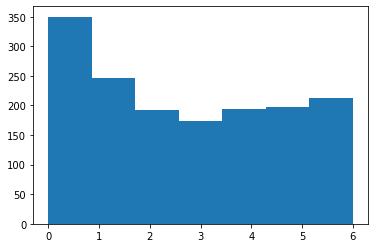

1568

In [86]:
# 다시 검증, 그럼 정확히 1주일일까?

plt.hist(longterm_user_tr_dow, bins=7)
plt.show()
len(longterm_user_tr_dow)

# longterm user들은 일요일에 가장 많이 주문하는 것으로 보이네요. 
# 일단 이 자료를 바탕으로 한 주의 마지막인 6(토요일)을 기준으로 집계된 것으로 가정하겠습니다.
# 집계 기간의 최대값이 365일이므로 이는 1년 단위의 주문 내역을 담은 것이고


dspo 합이 365인 고객들의 마지막 주문의 날짜가 다른 것은 집계된 마지막 주에 모두 거래가 있었음을 유추할 수 있습니다.
따라서 자료가 집계된 오늘은 토요일이며, 이를 시계열의 기준점으로 삼겠습니다. 

In [87]:
# 다시 이용기간이 362일인 고객들(dspo>=362일)의 id를 리스트로 받기
longterm_user_id =[]
longterm_limit = 362                             
for i, val in enumerate(dspo_series):
  if val >= longterm_limit:
    # print(i)
    longterm_user_id.append(i)
len(longterm_user_id) 

6606

In [88]:
# 이용기간이 362일 이상 사람들의 dspo 평균과 표준편차는 어떤가?

dspo_mean=[]
dspo_std=[]
for id in longterm_user_id:
  a = mk_list(id, 'days_since_prior_order')
  dspo_mean.append(np.mean(a).round(2))
  dspo_std.append(np.std(a).round(2))

# dspo_mean[1:10]
# dspo_std[1:10]

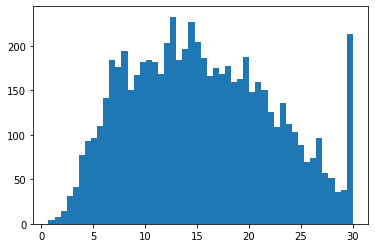

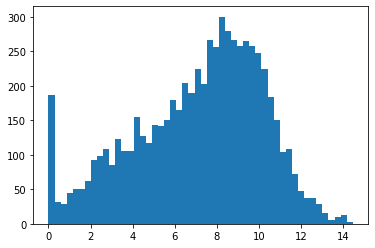

In [89]:
# 그래프 그려보자

plt.hist(dspo_mean, bins=50)      # 평균
plt.show()                          
plt.hist(dspo_std, bins=50)       # 표준편차
plt.show()


In [91]:
# 
p = 362
dspo_sum_series = no_30_df.groupby('user_id')['days_since_prior_order'].sum()
dspo_sum_series

for i in dspo_sum_series.index:
  if dspo_sum_series[i] < p:  
    # print(i)
    del dspo_sum_series[i]
    # dspo_sum_362[i] = int(dspo_sum[i])
    # print(dspo_sum[i])
    # print(dspo_sum_362[i])

# len(dspo_sum_362)                     # 이용 기간이 362인 고객이 5,962명()  / 363일은 5002 명으로 10%보다 작음. 

In [92]:
# # 자 이제 가장 난관인 시계열에 도전해 보자.
# # 기준은 11%의 꾸주니 고객들의 tr 요일 중 토요일을 오늘로 정하고 거기에 맞춰 order 발생 시점을 뒤로 옮기면서 기록한다.
# # 방법은 딕셔너리로 하며, 0은 집계 시작 시점이고 오늘(마지막 주 토요일)은 넉넉하게 450일 지난 시점으로 잡도록 하겠다.

# # 우선 확인: 고객 한명의 딕셔너리를 만들어 보자.
# # dict 초기화
# time_table = {key: 0 for key in range(401)}

# # VIP 고객 중 2번째 고객의 tr 발생한 요일 확인
# id = longterm_user_id[2]                 # 2번째 VIP
# last_dow = orders_df.loc[orders_df['user_id']==id, 'order_dow'].values[-1]      # tr의 dow = 4(목요일)

# # 400이 토요일이므로 목요일은 398 : 400 - (6-4)
# # 2번 VIP고객의 tr 발생 날짜는 398/ dspo는 398부터 시작
# last_order_day = 400- (6- last_dow)

# # 2번 VIP고객의 첫번째 주문 날짜는 398에서 dspo_sum을 뺀 날짜
# first_order_day = last_order_day - dspo_sum[id]                  # 33

# # dict에 값 추가 : 일단은 vip의 주문 횟수만 체크해 보자
# time_table[first_order_day] += 1

# # 다음 단계는 이전 거래 내역을 모두 기록하기
# order_day = first_order_day
# order_day += mk_list(id,'days_since_prior_order')[0]       # 첫번째 dspo를 더함

# # time_table에 기록
# time_table[order_day] += 1

#반복해보자.
time_table = {key: 0 for key in range(450)}

for id in dspo_sum_series.index:
  last_dow = orders_df.loc[orders_df['user_id']==id, 'order_dow'].values[-1]      # tr의 dow = 4(목요일)
  last_order_day = 400- (6- last_dow)

  first_order_day = last_order_day - dspo_sum_series[id]
  # print(i)
  # print(id)
  # print(last_dow)
  # print(last_order_day)
  # print(dspo_sum_series[id])
  # print(first_order_day)
  # print('----')

  order_day = first_order_day

  for dspo in mk_list(id,'days_since_prior_order'):
    order_day += dspo
    time_table[order_day] += 1

# longterm_user_id[0]
# sum(mk_list(50,'days_since_prior_order'))

dspo_sum_series

user_id
50        364.0
54        363.0
140       365.0
222       365.0
223       364.0
          ...  
205833    363.0
205908    365.0
206035    364.0
206053    362.0
206158    364.0
Name: days_since_prior_order, Length: 4054, dtype: float64

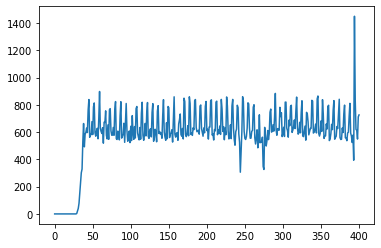

In [93]:
tt =time_table

tt_val = []
for i in range(401):
  tt_val.append(tt[i])

plt.plot(tt_val)


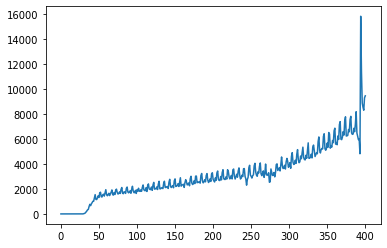

In [94]:
# 같은 방법으로 전체 고객의 시계열을 구해보자

# 다시 이용기간이 0 일 이상인 고객들(dspo>=362일)의 id를 리스트로 받기
longterm_user_id =[]
longterm_limit = 0                             
for i, val in enumerate(dspo_series):
  if val >= longterm_limit:
    # print(i)
    longterm_user_id.append(i)
len(longterm_user_id) 

# 
p = 0
dspo_sum_series = no_30_df.groupby('user_id')['days_since_prior_order'].sum()
dspo_sum_series

for i in dspo_sum_series.index:
  if dspo_sum_series[i] < p:  
    # print(i)
    del dspo_sum_series[i]
    # dspo_sum_362[i] = int(dspo_sum[i])
    # print(dspo_sum[i])
    # print(dspo_sum_362[i])

# len(dspo_sum_362)                     # 이용 기간이 362인 고객이 5,962명()  / 363일은 5002 명으로 10%보다 작음. 

#반복해보자.
time_table = {key: 0 for key in range(450)}

for id in dspo_sum_series.index:
  last_dow = orders_df.loc[orders_df['user_id']==id, 'order_dow'].values[-1]      # tr의 dow = 4(목요일)
  last_order_day = 400- (6- last_dow)

  first_order_day = last_order_day - dspo_sum_series[id]
  # print(i)
  # print(id)
  # print(last_dow)
  # print(last_order_day)
  # print(dspo_sum_series[id])
  # print(first_order_day)
  # print('----')

  order_day = first_order_day

  for dspo in mk_list(id,'days_since_prior_order'):
    order_day += dspo
    time_table[order_day] += 1

# longterm_user_id[0]
# sum(mk_list(50,'days_since_prior_order'))

# 시계열 그래프 그리기

tt =time_table

tt_val = []
for i in range(401):
  tt_val.append(tt[i])

plt.plot(tt_val)


## 다양한 그래프

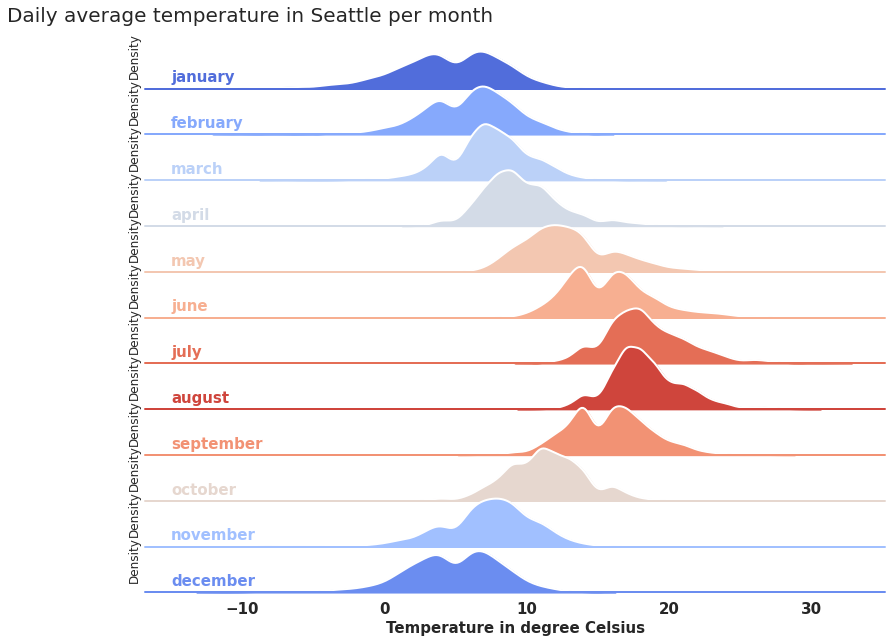

In [95]:
# getting necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# getting the data
temp = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2016-weather-data-seattle.csv') # we retrieve the data from plotly's GitHub repository
temp['month'] = pd.to_datetime(temp['Date']).dt.month # we store the month in a separate column

# we define a dictionnary with months that we'll use later
month_dict = {1: 'january',
              2: 'february',
              3: 'march',
              4: 'april',
              5: 'may',
              6: 'june',
              7: 'july',
              8: 'august',
              9: 'september',
              10: 'october',
              11: 'november',
              12: 'december'}

# we create a 'month' column
temp['month'] = temp['month'].map(month_dict)

# we generate a pd.Serie with the mean temperature for each month (used later for colors in the FacetGrid plot), and we create a new column in temp dataframe
month_mean_serie = temp.groupby('month')['Mean_TemperatureC'].mean()
temp['mean_month'] = temp['month'].map(month_mean_serie)


temp.head()

# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=12)

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(temp, row='month', hue='mean_month', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'Mean_TemperatureC',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'Mean_TemperatureC', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    ax.text(-15, 0.02, month_dict[i+1],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.3)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Temperature in degree Celsius', fontweight='bold', fontsize=15)
g.fig.suptitle('Daily average temperature in Seattle per month',
               ha='right',
               fontsize=20,
               fontweight=20)

plt.show()